# How to run a shell command using the `AiiDAShell` Node

## Introduction
`AiiDAShell` node is a built-in node, which uses the [aiida-shell](https://aiida-shell.readthedocs.io/en/latest/) package to run shell commands easy. Run any shell executable without writing a dedicated plugin or parser.

This tutorial is based on the [docs](https://aiida-shell.readthedocs.io/en/latest/howto.html#) of the `aiida-shell`

Load the AiiDA profile.

In [2]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## Running a shell command
Run a shell command without any arguments. Here we run the `date` command to show the date.

In [14]:
from aiida_worktree import WorkTree
from aiida_shell.launch import prepare_code

# Create a code on the local computer
code = prepare_code("date")

# Create a worktree
wt = WorkTree(name="test_shell_date")
job1 = wt.nodes.new("AiiDAShell", code=code)
wt.submit(wait=True)

# Print out the result:
print("\nResult: ", job1.node.outputs.stdout.get_content())

WorkTree node created, PK: 5585

Result:  Sa 20 Jan 2024 07:56:52 CET



## Running a shell command with arguments
To pass arguments to the shell command, pass them as a list of strings to the arguments keyword:

In [15]:
# Create a worktree
wt = WorkTree(name="test_shell_date_with_arguments")
job1 = wt.nodes.new("AiiDAShell", code=code, arguments=['--iso-8601'])
wt.submit(wait=True)

# Print out the result:
print("\nResult: ", job1.node.outputs.stdout.get_content())

WorkTree node created, PK: 5591

Result:  2024-01-20



## Running a shell command with files as arguments
For commands that take arguments that refer to files, pass those files using the nodes keyword. The keyword takes a dictionary of SinglefileData nodes. To specify where on the command line the files should be passed, use placeholder strings in the arguments keyword.

In [17]:
from aiida.orm import SinglefileData

# Create a code on the local computer
cat_code = prepare_code("cat")
# Create a worktree
wt = WorkTree(name="test_shell_cat_with_file_arguments")
job1 = wt.nodes.new("AiiDAShell", code=cat_code,
                    arguments=["{file_a}", "{file_b}"],
                    nodes={
                        'file_a': SinglefileData.from_string('string a'),
                        'file_b': SinglefileData.from_string('string b'),
                    },
                    )
wt.submit(wait=True)

# Print out the result:
print("\nResult: ", job1.node.outputs.stdout.get_content())

WorkTree node created, PK: 5604

Result:  string astring b


## Create a workflow
We want to calculate `(x+y)*z` in two steps using `echo` and `bc` commands.

Step 1: Calculate (x+y) and store it as result
```
result=$(echo "$x + $y" | bc)
```

Step 2: Multiply result by z and store the final result
```
result=$(echo "$result * $z" | bc)
```
Each step will invole two `ShellNode`s (`echo` and `bc`).

If one wanted to run this workflow in AiiDA, one would have to write plugins for `echo` and `bc` commands, and a WorkChain to handle the workflow. With aiida-worktree and the `AiiDAShell` node, this can be run through AiiDA with the following worktree:

In [34]:
from aiida_worktree import  node, WorkTree
from aiida_shell.launch import prepare_code
from aiida.orm import Int
from aiida_shell.data import PickledData


echo_code = prepare_code("echo")
bc_code = prepare_code("bc")

def parser(self, dirpath):
    from aiida.orm import Int
    return {'result': Int((dirpath / 'stdout').read_text().strip())}

@node()
def prepare_bc_nodes(file):
    """Prepare the nodes for the bc calculation."""
    return {"expression": file}

@node()
def prepare_echo_nodes(result, z):
    """Prepare the nodes for the echo calculation."""
    return {"result": result,
            "z": z,}

# Create a worktree
wt = WorkTree(name="shell_add_mutiply_workflow")
# echo x + y expression
job1 = wt.nodes.new("AiiDAShell", code=echo_code, arguments=["{x}", "+", "{y}"],
                    nodes={
                        'x': Int(2),
                        'y': Int(3),
                    },
                )
# bc command to calculate the expression
job2 = wt.nodes.new("AiiDAShell", code=bc_code, arguments=["{expression}"],
                    filenames={'expression': 'input.txt'},
                    parser=PickledData(parser),
                )
# add a "result" output socket from the parser
job2.outputs.new("General", "result")
# echo result + y expression
job3 = wt.nodes.new("AiiDAShell", code=echo_code, arguments=["{result}", "*", "{z}"],
                )
# bc command to calculate the expression
job4 = wt.nodes.new("AiiDAShell", code=bc_code, arguments=["{expression}"],
                    filenames={'expression': 'input.txt'},
                    parser=PickledData(parser),
                )
# prepare the nodes for the bc calculation
nodes1 = wt.nodes.new(prepare_bc_nodes)
nodes2 = wt.nodes.new(prepare_echo_nodes, z=Int(4))
nodes3 = wt.nodes.new(prepare_bc_nodes)

wt.links.new(job1.outputs["stdout"], nodes1.inputs[0])
wt.links.new(nodes1.outputs[0], job2.inputs["nodes"])
wt.links.new(job2.outputs["result"], nodes2.inputs[0])
wt.links.new(nodes2.outputs[0], job3.inputs["nodes"])
wt.links.new(job3.outputs["stdout"], nodes3.inputs[0])
wt.links.new(nodes3.outputs[0], job4.inputs["nodes"])
wt.submit(wait=True)

WorkTree node created, PK: 6213


In [36]:
print("State of WorkTree    : {}".format(wt.state))
print('Result               : {}'.format(job4.node.outputs.result.value))

State of WorkTree    : FINISHED
Result               : 20


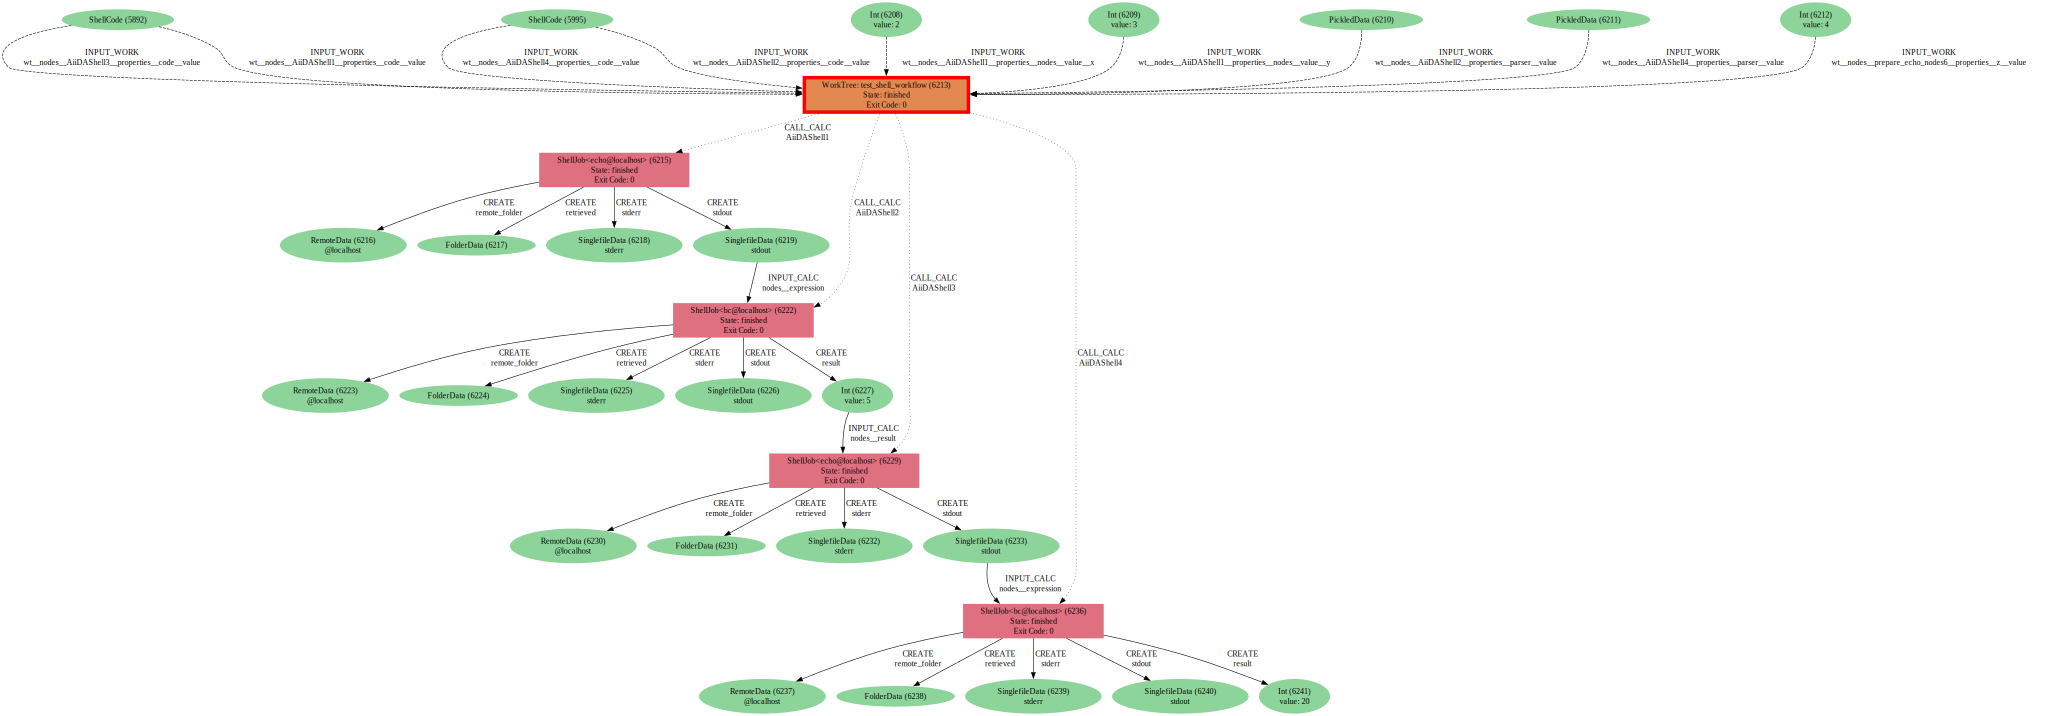

In [37]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)

## What's Next
For more examples of `aiida-shell`, please refer to its [docs](https://aiida-shell.readthedocs.io/en/latest/howto.html#)